# EDA of the dataset

### Our datasets
main dataset  - ["European Soccer Database" (ESD)](https://www.kaggle.com/hugomathien/soccer//) 

Additional datasets -

- "UK football stadiums" -  [UK stadiums description](https://www.doogal.co.uk/FootballStadiums.php//) 
- Position in league table per stage - from [worldfootball](https://www.worldfootball.net/schedule//)

The "European Soccer Database" consists of three main tables:
- Match - features for each match of 2008-2016 seasons
- Player -  player attributes
- Team - team attributes

The worldfootball dataset was extracted directly from the website. In order to receive the position of each team in each stage of the league we wrote a script named extract_table_from_url(attached together with this file) which goes through pages such as [this](http://www.worldfootball.net/schedule/eng-premier-league-2016-2017-spieltag/9/) and write the data to an csv file. 



### EDA update 

In this notebook we worked on three issues:
1) Engineering new features 
2) Dealing with draw class poor prediction rates
3) Using Different classification models


#### New features:
- points - number of points in current league stage
- norm_points - number of points in current league stage relative to highest number of points in current stage
- position - position in league table
- straight_wins - if last game was won, number of wins in a row
- straight_loses - if last game was lost, number of losses in a row
- straight_draws - - if last game ended with a draw, number of draws in a row 
- pos_goals - goals scored in last X games
- neg_goals - goals received in last X games
- tot_pos_goals - goals scored since the begining of the season
- tot_neg_goals - goals received since the begining of the season
- goals_diff - tot_pos_goals minus tot_neg_goals
- wins - wins in last X games 
- loses - loses in last X games

X is the size of the moving window we used.
In this file we set X to be 5, in the future we will try different size for X.
All of these features were created for both home and away team for each match. 

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we tried two methods, both based on demanding a certain threshold crossing for a win/ lose decision:
1) relative threshold - the threshold is determined on the percentage win and lose cases takes out of 1.
2) absolute threshold -  win/lose classed needs to cross a predetermined threshold in order for them to be picked

#### Classification models:

In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- A combination of all models

After trying all of these models the best f1-score was received using Logistic Regression with the second type of threshold.



#### General Impotrs:

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle

def save_obj(obj, name ):
    with open('databases/objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('databases/objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Read all DB's:

In [3]:
#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

current_leagues = ["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [4]:
window_size = load_obj("window_size")

In [5]:
basic_info       = ["index","league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
last_games_wld   = [str(x)+"_last_wld" for x in list(range(1,window_size))]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","pos_goals","neg_goals","tot_pos_goals","tot_neg_goals","goals_diff","wins","loses"] + last_games_wld
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","away_win_season_percent","away_lose_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","away_win_percent","away_lose_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

In [6]:
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds # + ["stage"]
labels_list   = "win_lose_draw"

In [7]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

In [8]:
all_leagues = final_matches_db["league"].unique()

for league in all_leagues:
    if league.replace(" ","_") in current_leagues: continue
    final_matches_db = final_matches_db[final_matches_db["league"] != league]

In [9]:
final_matches_db.reset_index(inplace=True)

In [10]:
final_matches_db

,index,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.000000,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.50,4.50,5.50,0
1,1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.000000,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.50,5.50,6.00,1
2,2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.000000,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.60,3.30,3.80,2
3,3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.000000,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.40,3.20,3.50,1
4,4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.000000,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.40,3.20,3.50,1
5,5,England Premier League,2008/2009,1,Everton,Blackburn Rovers,2 - 3,0.0,0.000000,0.0,...,2.00,1.95,2.05,4.00,3.50,4.00,3.30,3.10,3.30,2
6,6,England Premier League,2008/2009,1,Middlesbrough,Tottenham Hotspur,2 - 1,0.0,0.000000,0.0,...,3.20,2.90,3.20,2.25,2.15,2.30,3.40,3.20,3.40,1
7,7,England Premier League,2008/2009,1,Bolton Wanderers,Stoke City,3 - 1,0.0,0.000000,0.0,...,1.83,1.80,1.85,4.50,4.00,4.80,3.50,3.10,3.40,1
8,8,England Premier League,2008/2009,1,Hull City,Fulham,2 - 1,0.0,0.000000,0.0,...,2.60,2.50,2.60,2.80,2.62,2.80,3.20,2.90,3.40,1
9,9,England Premier League,2008/2009,1,Chelsea,Portsmouth,4 - 0,0.0,0.000000,0.0,...,1.33,1.30,1.33,10.00,8.50,11.00,5.00,4.20,5.00,1


#### Functions:

#### Hyperparameters:

In [11]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.40
seed        = 101

threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Data Visualizations:

In [12]:
#sns.pairplot(new_matches[features_list].dropna(axis=0))

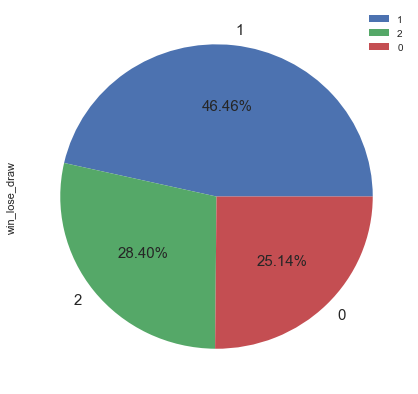

In [13]:
final_matches_db["win_lose_draw"].value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

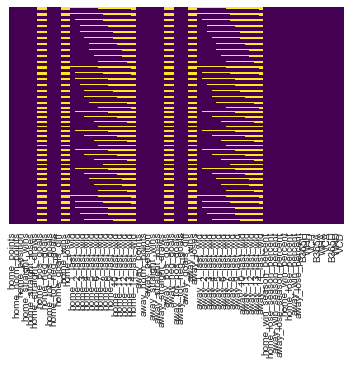

In [14]:
sns.heatmap(final_matches_db[features_list].isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Split the data:

In [15]:
from sklearn.model_selection import train_test_split
import random

In [16]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_seasons = features["season"].unique()
    all_leagues = features["league"].unique()
    
    num_of_seasons    = len(all_seasons)
    test_num_seasons  = round(num_of_seasons*test_size)
    train_num_seasons = num_of_seasons-test_num_seasons
        
    for league in all_leagues:
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

In [17]:
def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

In [18]:
temp      = final_matches_db.dropna(axis = 0)
info_list = ["index","league","season","stage","home_team_name","away_team_name"]
features  = temp[info_list + features_list]
labels    = temp[info_list + [labels_list]]

In [19]:
print("Num of features =",len(features_list))

Num of features = 71


In [20]:
X_train_original, X_test_original, y_train_original, y_test_original = get_split_func(split_mode)(features, labels, test_size=test_size, random_state=seed)

**England Premier League:**

train_leagues = ['2009/2010' '2014/2015' '2013/2014' '2008/2009' '2015/2016']
test_leagues  = ['2010/2011' '2012/2013' '2011/2012']


**France Ligue 1:**

train_leagues = ['2014/2015' '2012/2013' '2010/2011' '2009/2010' '2011/2012']
test_leagues  = ['2013/2014' '2015/2016' '2008/2009']


**Germany 1. Bundesliga:**

train_leagues = ['2012/2013' '2015/2016' '2013/2014' '2014/2015' '2008/2009']
test_leagues  = ['2010/2011' '2011/2012' '2009/2010']


**Netherlands Eredivisie:**

train_leagues = ['2015/2016' '2011/2012' '2010/2011' '2012/2013' '2009/2010']
test_leagues  = ['2013/2014' '2008/2009' '2014/2015']


**Spain LIGA BBVA:**

train_leagues = ['2011/2012' '2008/2009' '2013/2014' '2015/2016' '2014/2015']
test_leagues  = ['2010/2011' '2009/2010' '2012/2013']


In [21]:
X_train = X_train_original[features_list]
X_test  = X_test_original[features_list]
y_train = y_train_original[labels_list]
y_test  = y_test_original[labels_list]

In [22]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3231 entries, 900 to 12875
Data columns (total 71 columns):
home_points                 3231 non-null float64
home_norm_points            3231 non-null float64
home_position               3231 non-null float64
home_straight_wins          3231 non-null float64
home_straight_loses         3231 non-null float64
home_straight_draws         3231 non-null float64
home_pos_goals              3231 non-null float64
home_neg_goals              3231 non-null float64
home_tot_pos_goals          3231 non-null float64
home_tot_neg_goals          3231 non-null float64
home_goals_diff             3231 non-null float64
home_wins                   3231 non-null float64
home_loses                  3231 non-null float64
home_1_last_wld             3231 non-null float64
home_2_last_wld             3231 non-null float64
home_3_last_wld             3231 non-null float64
home_4_last_wld             3231 non-null float64
home_5_last_wld             3231 non-nul

####  Logistic Regression model

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logmodel = LogisticRegression()

In [25]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
predictions = logmodel.predict(X_test)

#### Learning Evaluation:

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

In [28]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.38      0.05      0.09       840
          1       0.53      0.85      0.65      1487
          2       0.49      0.40      0.44       904

avg / total       0.48      0.52      0.45      3231



In [29]:
print(confusion_matrix(y_test,predictions))

[[  44  612  184]
 [  41 1263  183]
 [  32  514  358]]


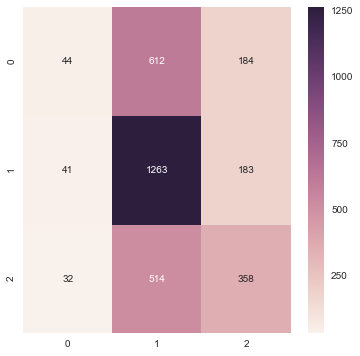

In [30]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True, fmt="d")

In [31]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features_list,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,0.016735,-0.002464,-0.013385
home_norm_points,0.139736,-0.205256,-0.099415
home_position,0.031057,-0.015054,-0.018589
home_straight_wins,-0.012534,0.029317,-0.035189
home_straight_loses,-0.005868,-0.025703,0.029330
home_straight_draws,0.144510,-0.117292,-0.022545
home_pos_goals,-0.034636,0.005955,0.027996
home_neg_goals,0.028594,-0.011043,-0.016531
home_tot_pos_goals,-0.004214,0.005934,-0.002157
home_tot_neg_goals,-0.008693,0.007830,-0.000681


#### Adding thresold to Logistic Regression model

In [32]:
soft_decision = logmodel.predict_proba(X_test)

In [33]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [34]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [35]:
for thresh,prediction in new_predictions.items():
    printmd('**threshold = ' + thresh + '**')
    print(classification_report(y_test,prediction))
    print(confusion_matrix(y_test,prediction),"\n\n")

**threshold = threshold_2**

             precision    recall  f1-score   support

          0       0.30      0.24      0.27       840
          1       0.58      0.68      0.62      1487
          2       0.48      0.44      0.46       904

avg / total       0.48      0.50      0.48      3231

[[ 199  431  210]
 [ 262 1014  211]
 [ 195  315  394]] 




**threshold = threshold_1**

             precision    recall  f1-score   support

          0       0.29      0.29      0.29       840
          1       0.57      0.74      0.64      1487
          2       0.56      0.26      0.36       904

avg / total       0.49      0.49      0.47      3231

[[ 246  486  108]
 [ 305 1100   82]
 [ 311  356  237]] 




#### Adding more models:

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [37]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

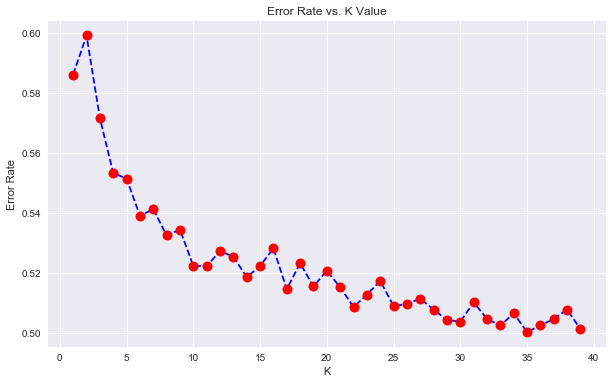

In [38]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [39]:
best_n_neighbors = error_rate.index(min(error_rate))+1
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 35


In [40]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [41]:
svm = SVC()

In [42]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
svm_grid   = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

#### Decision Tree:

In [43]:
dtree = DecisionTreeClassifier()

In [44]:
rfc = RandomForestClassifier(n_estimators=600)

#### Train and Predict using all model:

In [45]:
all_models         = [knn,svm,svm_grid,rfc,dtree]
models_predictions = {}

for thresh,prediction in new_predictions.items():
    models_predictions[str(logmodel).split("(")[0] + " " + thresh] = prediction

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train,y_train)
    models_predictions[classifier_name] = model.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] gamma=1, C=0.1 ..................................................
[CV] ................... gamma=1, C=0.1, score=0.476111, total=   3.3s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.476085, total=   3.3s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.476349, total=   3.5s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.476111, total=   2.5s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.476085, total=   3.2s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.476349, total=   3.2s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.476111, total=   2.4s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.476085, total=   2.9s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.476349, total=   2.2s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] .

[CV] .................. gamma=1, C=1000, score=0.476111, total=   3.4s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.476085, total=   3.4s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.476349, total=   3.4s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.476111, total=   2.7s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.476085, total=   2.6s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.476349, total=   2.6s
[CV] gamma=0.01, C=1000 ..............................................
[CV] ............... gamma=0.01, C=1000, score=0.457222, total=   2.3s
[CV] gamma=0.01, C=1000 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.4min finished


In [46]:
for model_name,model_prediction in models_predictions.items():
    printmd('**classifier = ' + model_name + '**')
    print(classification_report(y_test,model_prediction))
    print(confusion_matrix(y_test,model_prediction),"\n\n")

**classifier = RandomForestClassifier**

             precision    recall  f1-score   support

          0       0.43      0.04      0.07       840
          1       0.53      0.86      0.66      1487
          2       0.51      0.42      0.46       904

avg / total       0.50      0.52      0.45      3231

[[  30  615  195]
 [  24 1284  179]
 [  15  507  382]] 




**classifier = KNeighborsClassifier**

             precision    recall  f1-score   support

          0       0.31      0.11      0.16       840
          1       0.53      0.81      0.64      1487
          2       0.48      0.35      0.40       904

avg / total       0.46      0.50      0.45      3231

[[  92  582  166]
 [ 110 1208  169]
 [  92  498  314]] 




**classifier = LogisticRegression threshold_2**

             precision    recall  f1-score   support

          0       0.30      0.24      0.27       840
          1       0.58      0.68      0.62      1487
          2       0.48      0.44      0.46       904

avg / total       0.48      0.50      0.48      3231

[[ 199  431  210]
 [ 262 1014  211]
 [ 195  315  394]] 




**classifier = SVC**

             precision    recall  f1-score   support

          0       0.36      0.02      0.03       840
          1       0.47      0.97      0.63      1487
          2       0.42      0.04      0.07       904

avg / total       0.42      0.46      0.32      3231

[[  15  803   22]
 [  15 1447   25]
 [  12  858   34]] 




**classifier = GridSearchCV**

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       840
          1       0.51      0.92      0.66      1487
          2       0.54      0.31      0.39       904

avg / total       0.38      0.51      0.41      3231

[[   0  708  132]
 [   0 1375  112]
 [   1  621  282]] 




**classifier = DecisionTreeClassifier**

             precision    recall  f1-score   support

          0       0.27      0.27      0.27       840
          1       0.54      0.56      0.55      1487
          2       0.39      0.36      0.37       904

avg / total       0.43      0.43      0.43      3231

[[226 393 221]
 [353 833 301]
 [244 331 329]] 




**classifier = LogisticRegression threshold_1**

             precision    recall  f1-score   support

          0       0.29      0.29      0.29       840
          1       0.57      0.74      0.64      1487
          2       0.56      0.26      0.36       904

avg / total       0.49      0.49      0.47      3231

[[ 246  486  108]
 [ 305 1100   82]
 [ 311  356  237]] 




#### Nueral Network model

In [47]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras import regularizers
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Using TensorFlow backend.


In [48]:
L   = [100,100]
dim = len(features_list)
k   = 3

nb_epoch   = 100
batch_size = 1500
dropout    = 0.5
regularization_factor = 0.01

X_train_mat = X_train.as_matrix()
X_test_mat  = X_test.as_matrix()
y_train_mat = y_train.as_matrix()
y_test_mat  = y_test.as_matrix()
Y_train_mat = np_utils.to_categorical(y_train, k)
Y_test_mat  = np_utils.to_categorical(y_test, k)

In [49]:
# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train_norm = normalizer.transform(X_train)                            
# X_test_norm = normalizer.transform(X_test)    
X_train_mat.max()

117.0

In [50]:
nn_model = Sequential()
nn_model.add(Dense(L[0], input_dim=dim, init='normal', activation='relu'))
nn_model.add(Dropout(dropout))
for ii in range(1,len(L)):
    nn_model.add(Dense(L[ii], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'))
    nn_model.add(Dropout(dropout))
nn_model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_dim=71, activation="relu", kernel_initializer="normal")`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_regularizer=<keras.reg..., kernel_initializer="normal", activation="relu")`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_regularizer=<keras.reg..., kernel_initializer="normal", activation="softmax")`
  import sys


In [51]:
nn_model.fit(X_train_mat, Y_train_mat, nb_epoch=nb_epoch, batch_size=batch_size,validation_data=(X_test_mat, Y_test_mat),shuffle=True, callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 5395 samples, validate on 3231 samples
Epoch 1/100
5395/5395 [==============================] - 2s - loss: 1.6807 - categorical_accuracy: 0.3277 - val_loss: 1.3414 - val_categorical_accuracy: 0.4602
Epoch 2/100
5395/5395 [==============================] - 0s - loss: 1.4425 - categorical_accuracy: 0.4354 - val_loss: 1.2998 - val_categorical_accuracy: 0.4639
Epoch 3/100
5395/5395 [==============================] - 0s - loss: 1.3377 - categorical_accuracy: 0.4578 - val_loss: 1.2289 - val_categorical_accuracy: 0.4989
Epoch 4/100
5395/5395 [==============================] - 0s - loss: 1.2509 - categorical_accuracy: 0.4719 - val_loss: 1.2113 - val_categorical_accuracy: 0.5119
Epoch 5/100
5395/5395 [==============================] - 0s - loss: 1.2187 - categorical_accuracy: 0.4801 - val_loss: 1.1933 - val_categorical_accuracy: 0.5067
Epoch 6/100
5395/5395 [==============================] - 0s - loss: 1.2030 - categorical_accuracy: 0.4901 - val_loss: 1.1750 - val_categorical_accuracy:

5395/5395 [==============================] - 0s - loss: 0.9988 - categorical_accuracy: 0.5375 - val_loss: 1.0140 - val_categorical_accuracy: 0.5153
Epoch 52/100
5395/5395 [==============================] - 0s - loss: 0.9980 - categorical_accuracy: 0.5353 - val_loss: 1.0130 - val_categorical_accuracy: 0.5138
Epoch 53/100
5395/5395 [==============================] - 0s - loss: 0.9964 - categorical_accuracy: 0.5323 - val_loss: 1.0121 - val_categorical_accuracy: 0.5132
Epoch 54/100
5395/5395 [==============================] - 0s - loss: 0.9996 - categorical_accuracy: 0.5331 - val_loss: 1.0120 - val_categorical_accuracy: 0.5135
Epoch 55/100
5395/5395 [==============================] - 0s - loss: 0.9961 - categorical_accuracy: 0.5342 - val_loss: 1.0118 - val_categorical_accuracy: 0.5150
Epoch 56/100
5395/5395 [==============================] - 0s - loss: 0.9952 - categorical_accuracy: 0.5325 - val_loss: 1.0111 - val_categorical_accuracy: 0.5166
Epoch 57/100
5395/5395 [=======================

In [52]:
final_predictions = nn_model.predict_classes(X_test_mat, verbose=1)
print(classification_report(y_test_mat,final_predictions))
print(confusion_matrix(y_test_mat,final_predictions))

3008/3231 [==========================>...] - ETA: 0s             precision    recall  f1-score   support

          0       0.00      0.00      0.00       840
          1       0.53      0.86      0.66      1487
          2       0.49      0.43      0.46       904

avg / total       0.38      0.52      0.43      3231

[[   0  635  205]
 [   0 1284  203]
 [   0  513  391]]


C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


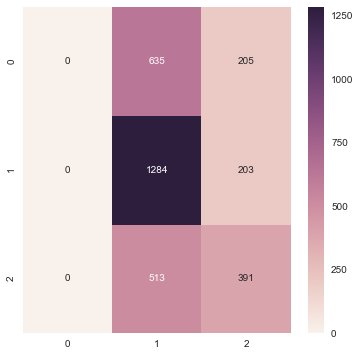

In [53]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_mat,final_predictions),annot=True, fmt="d")

### Save all soft decisions:
(in the future will include LSTM too)

In [54]:
chosen_data  = X_test
soft_decision_models = [rfc,knn,logmodel,dtree,nn_model]

all_soft_decisions = {}

for model in soft_decision_models:
    classifier_name = str(model).split("(")[0]
    if model == nn_model:
        classifier_name = "nn_model"
        
    all_soft_decisions[model] = model.predict_proba(chosen_data.as_matrix())
    #hard_decision             = model.predict(chosen_data.as_matrix())
    
    soft_decision_df = pd.DataFrame(all_soft_decisions[model],index = chosen_data.index,columns = ["MYD","MYH","MYA"])
    #hard_decision_df = pd.DataFrame(hard_decision,index = chosen_data.index)
    
    soft_decision_df.to_csv("databases/my_predictions/" + classifier_name + ".csv")

3104/3231 [===========================>..] - ETA: 0s

#### Combine all predictions into one:

In [55]:
final_soft_decision = np.mean(list(all_soft_decisions.values()),axis=0)
final_hard_decision = final_soft_decision.argmax(axis=1)

print(classification_report(y_test,final_hard_decision.T))
print(confusion_matrix(y_test,final_hard_decision.T))

             precision    recall  f1-score   support

          0       0.28      0.19      0.23       840
          1       0.55      0.70      0.62      1487
          2       0.46      0.40      0.43       904

avg / total       0.46      0.48      0.46      3231

[[ 157  486  197]
 [ 215 1047  225]
 [ 179  366  359]]


In [56]:
soft_decision_df = pd.DataFrame(final_soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])

soft_decision_df.to_csv("databases/my_predictions/final_soft_decision.csv")

In [57]:
# num_of_clasifers  = len(models_predictions)
# len_of_prediction = len(X_test)

# all_predictions = np.concatenate(list(models_predictions.values()),axis=0)
# all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T

In [58]:
# final_predictions = []
# for i in range(0,len_of_prediction):
#     predicted_class,count = np.unique(all_predictions[i],return_counts=True)
#     dic = dict(zip(predicted_class,count))
#     if 0 in list(dic) and dic[0] > 1: final_class = 0
#     else: final_class = max(dic)
#     final_predictions.append(final_class)

In [59]:
# print(classification_report(y_test,final_predictions))
# print(confusion_matrix(y_test,final_predictions))

In [60]:
# plt.figure(figsize=(6, 6))
# sns.heatmap(confusion_matrix(y_test,final_predictions),annot=True, fmt="d")

### LSTM

In [61]:
def func1(x,temp_dic,home_away,team):
    temp_dic[home_away]              = x.loc[(x[home_away + "_team_name"] == team)].copy()
    temp_dic[home_away]["home_away"] = home_away
    
def get_df(x,func,func_data):
    temp_dic = {}
    for home_away in ["home", "away"]:
        func(x,temp_dic,home_away,func_data)
    return temp_dic["home"].append(temp_dic["away"]).sort_values(["season","stage"])

In [62]:
new_matches_LSTM = final_matches_db
all_teams_LSTM = final_matches_db["home_team_name"].unique()
all_seasons_LSTM = final_matches_db['season'].unique()

In [63]:
all_leagues

array(['England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga',
       'Netherlands Eredivisie', 'Spain LIGA BBVA'], dtype=object)

In [64]:
tested_league = ['Netherlands Eredivisie']

In [65]:
new_matches_LSTM.dropna(inplace=True)
num_total = []
for league in all_leagues:
    min_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].min()
    max_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].max()
    print(min_stage)
    print(max_stage)
    num_of_stages    = max_stage - min_stage + 1
    num_total.append(num_of_stages)
num_total
max_stages = np.max(num_total)
num_of_features = len(features_list)

15
38
15
38
15
34
15
34
15
38


In [66]:
np.zeros([1,2,2])

array([[[ 0.,  0.],
        [ 0.,  0.]]])

In [67]:
new_matches_LSTM

,index,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
140,140,England Premier League,2008/2009,15,Liverpool,West Ham United,0 - 0,33.0,1.000000,2.0,...,1.30,1.29,1.30,12.00,8.50,11.00,5.00,4.33,5.00,0
141,141,England Premier League,2008/2009,15,Sunderland,Bolton Wanderers,1 - 4,15.0,0.454545,17.0,...,2.25,2.25,2.25,3.30,2.75,3.20,3.30,3.20,3.30,2
142,142,England Premier League,2008/2009,15,Tottenham Hotspur,Everton,0 - 1,15.0,0.454545,16.0,...,1.91,1.95,2.00,4.00,3.30,3.80,3.50,3.25,3.30,2
143,143,England Premier League,2008/2009,15,Aston Villa,Fulham,0 - 0,24.0,0.727273,4.0,...,1.57,1.57,1.60,6.50,5.00,6.00,3.80,3.50,3.60,0
144,144,England Premier League,2008/2009,15,Middlesbrough,Newcastle United,0 - 0,18.0,0.545455,10.0,...,2.20,2.10,2.20,3.40,3.10,3.40,3.30,3.10,3.25,0
145,145,England Premier League,2008/2009,15,Manchester City,Manchester United,0 - 1,17.0,0.515152,11.0,...,4.33,4.33,4.20,1.83,1.73,1.90,3.60,3.20,3.40,2
146,146,England Premier League,2008/2009,15,Portsmouth,Blackburn Rovers,3 - 2,19.0,0.575758,8.0,...,2.10,2.00,2.10,3.60,3.20,3.60,3.30,3.20,3.25,1
147,147,England Premier League,2008/2009,15,Stoke City,Hull City,1 - 1,17.0,0.515152,14.0,...,2.40,2.25,2.40,2.88,2.75,2.90,3.40,3.20,3.30,0
148,148,England Premier League,2008/2009,15,Wigan Athletic,West Bromwich Albion,2 - 1,16.0,0.484848,15.0,...,1.73,1.83,1.72,5.00,3.75,5.00,3.60,3.20,3.60,1
149,149,England Premier League,2008/2009,15,Chelsea,Arsenal,1 - 2,33.0,1.000000,1.0,...,1.80,1.67,1.73,5.00,4.50,5.00,3.40,3.30,3.50,2


In [68]:
new_matches_LSTM.columns

Index(['index', 'league', 'season', 'stage', 'home_team_name',
       'away_team_name', 'score', 'home_points', 'home_norm_points',
       'home_position', 'home_straight_wins', 'home_straight_loses',
       'home_straight_draws', 'home_pos_goals', 'home_neg_goals',
       'home_tot_pos_goals', 'home_tot_neg_goals', 'home_goals_diff',
       'home_wins', 'home_loses', 'home_1_last_wld', 'home_2_last_wld',
       'home_3_last_wld', 'home_4_last_wld', 'home_5_last_wld',
       'home_6_last_wld', 'home_7_last_wld', 'home_8_last_wld',
       'home_9_last_wld', 'home_10_last_wld', 'home_11_last_wld',
       'home_12_last_wld', 'home_13_last_wld', 'home_14_last_wld',
       'away_points', 'away_norm_points', 'away_position',
       'away_straight_wins', 'away_straight_loses', 'away_straight_draws',
       'away_pos_goals', 'away_neg_goals', 'away_tot_pos_goals',
       'away_tot_neg_goals', 'away_goals_diff', 'away_wins', 'away_loses',
       'away_1_last_wld', 'away_2_last_wld', 'away_3_las

In [69]:
def LSTM_matrix_league_pad(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league = {}
    LSTM_matches_league = {}
    index_league = {}
    min_stage = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp = temp[features_list] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)

                if first_iter:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)

                        label_pad = np.zeros([1,columns_to_fill])
                        label_pad = np_utils.to_categorical(label_pad, k)
                        label_pad = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                        
                    label_league[league] = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league] = matches_temp
                    first_iter = False

                else:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)
                        
                        label_pad = np.zeros([1,columns_to_fill])
                        label_pad = np_utils.to_categorical(label_pad, k)
                        label_pad = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                    
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league] = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league] = np.concatenate((index_league[league], matches_temp), axis=0)
        print(league,np.shape(LSTM_matches_league[league]))
        min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [70]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)
LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad = LSTM_matrix_league_pad(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad = LSTM_matrix_league_pad(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (100, 24, 71)
France Ligue 1 (100, 24, 71)
Germany 1. Bundesliga (90, 24, 71)
Netherlands Eredivisie (90, 24, 71)
Spain LIGA BBVA (100, 24, 71)
England Premier League (60, 24, 71)
France Ligue 1 (60, 24, 71)
Germany 1. Bundesliga (54, 24, 71)
Netherlands Eredivisie (54, 24, 71)
Spain LIGA BBVA (60, 24, 71)


In [71]:
def LSTM_matrix_league(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league = {}
    LSTM_matches_league = {}
    index_league = {}
    min_stage = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#                 print(matches_per_team_season)
#                 return
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp = temp[features_list] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
#                 print(matches_per_team_season_mat.shape[1])
                
                if first_iter:
                    label_league[league] = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league] = matches_temp
                    first_iter = False
                    current_stage_num = np.shape(LSTM_matches_league[league])[1]
                else:
                    if np.shape(matches_per_team_season_mat)[1] != current_stage_num:
                        continue
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league] = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league] = np.concatenate((index_league[league], matches_temp), axis=0)
        print(league,np.shape(LSTM_matches_league[league]))
        min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [72]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)
LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train = LSTM_matrix_league(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test = LSTM_matrix_league(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (100, 24, 71)
France Ligue 1 (96, 24, 71)
Germany 1. Bundesliga (90, 20, 71)
Netherlands Eredivisie (2, 18, 71)
Spain LIGA BBVA (100, 24, 71)
England Premier League (60, 24, 71)
France Ligue 1 (54, 24, 71)
Germany 1. Bundesliga (54, 20, 71)
Netherlands Eredivisie (10, 19, 71)
Spain LIGA BBVA (58, 24, 71)


In [73]:
# LSTM_matches_league_test,label_league_test,index_league_test = LSTM_matrix_league(new_matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM)

In [74]:
# Y_train_league = {}
# LSTM_matches_league = {}
# Matches_id_league = {}
# min_stage = float('inf')

# first_iter = True
# for league in all_leagues:
#     for team in all_teams_LSTM:
#         for season in all_seasons_LSTM:
#             matches_per_team        = get_df(new_matches_LSTM[new_matches_LSTM['league']==league],func1,team)
#             matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#             if len(matches_per_team_season.index) == 0: continue
#             temp = matches_per_team_season.dropna(axis = 0)

#             matches_temp = temp['index'].as_matrix()
#             matches_temp = np.expand_dims(matches_temp, axis=0)
            
#             labels_temp = temp['win_lose_draw'].as_matrix()
#             labels_temp_bin = np_utils.to_categorical(labels_temp, k)
#             labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

#             features_temp = temp[new_new_columns] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
#             matches_per_team_season_mat = features_temp.as_matrix()
#             matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)

#             if first_iter:
#                 Y_train_league[league] = labels_temp_bin
#                 LSTM_matches_league[league] = matches_per_team_season_mat
#                 Matches_id_league[league] = matches_temp
#                 first_iter = False
#                 current_stage_num = np.shape(LSTM_matches_league[league])[1]
#             else:
#                 if np.shape(matches_per_team_season_mat)[1] != current_stage_num:
# #                     print(np.shape(matches_per_team_season_mat)[1])
#                     continue
#                 LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
#                 Y_train_league[league] = np.concatenate((Y_train_league[league], labels_temp_bin), axis=0)
#                 Matches_id_league[league] = np.concatenate((Matches_id_league[league], matches_temp), axis=0)
                
#     print(league,np.shape(LSTM_matches_league[league]))
#     min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
#     first_iter = True

In [75]:
def LSTM_matrix(LSTM_matches_league,label_league,index_league,min_stage,all_leagues ):
    first_iter = True
    for league in all_leagues:
        if first_iter:
            labels = label_league[league][:,0:min_stage,:]
            LSTM_matches = LSTM_matches_league[league][:,0:min_stage,:]
            indexs = index_league[league][:,0:min_stage]
            first_iter = False
        else:
            LSTM_matches = np.concatenate((LSTM_matches, LSTM_matches_league[league][:,0:min_stage,:]), axis=0)
            labels = np.concatenate((labels,  label_league[league][:,0:min_stage,:]), axis=0)
            indexs = np.concatenate((indexs,  index_league[league][:,0:min_stage]), axis=0)
    return (LSTM_matches,labels,indexs)

In [76]:
pad_flag = True 
if pad_flag:    
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad,all_leagues)
    X_test,y_test,index_test = LSTM_matrix(LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad,all_leagues)
else:
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train,all_leagues)
    X_test,y_test,index_test = LSTM_matrix(LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test,all_leagues)

In [77]:
print(X_train.shape,y_train.shape,index_train.shape,X_test.shape,y_test.shape,index_test.shape)

(480, 24, 71) (480, 24, 3) (480, 24) (288, 24, 71) (288, 24, 3) (288, 24)


In [78]:
# first_iter = True
# for league in all_leagues:
#     if first_iter:
#         Y_train = Y_train_league[league][:,0:min_stage,:]
#         LSTM_matches = LSTM_matches_league[league][:,0:min_stage,:]
#         Matches_id = Matches_id_league[league][:,0:min_stage]
#         first_iter = False
#     else:
#         LSTM_matches = np.concatenate((LSTM_matches, LSTM_matches_league[league][:,0:min_stage,:]), axis=0)
#         Y_train = np.concatenate((Y_train,  Y_train_league[league][:,0:min_stage,:]), axis=0)
#         Matches_id = np.concatenate((Matches_id,  Matches_id_league[league][:,0:min_stage]), axis=0)

In [79]:
# first_iter = True
# for team in all_teams_LSTM:
#     for season in all_seasons_LSTM:
#         matches_per_team        = get_df(new_matches_LSTM,func1,team)
#         matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
#         if len(matches_per_team_season.index) == 0: continue
#         temp = matches_per_team_season.dropna(axis = 0)
        
#         labels_temp = temp['win_lose_draw'].as_matrix()
#         labels_temp_bin = np_utils.to_categorical(labels_temp, k)
#         labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)
        
#         features_temp = temp[new_new_columns] #+ temp[betting_odds]# + ["stage"] + ["stadium_capcity"]
#         matches_per_team_season_mat = features_temp.as_matrix()
#         matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
        
#         if first_iter:
#             Y_train = labels_temp_bin
#             LSTM_matches = matches_per_team_season_mat
#             first_iter = False
#         else:
#             LSTM_matches = np.concatenate((LSTM_matches, matches_per_team_season_mat), axis=0)
#             Y_train = np.concatenate((Y_train, labels_temp_bin), axis=0)
            


In [80]:
# X_train, X_test, y_train, y_test,matches_train,matches_test = train_test_split(LSTM_matches, Y_train,Matches_id, test_size=0.30, random_state=103)

In [81]:
# preprocessing
preprocessing_flag = True
if preprocessing_flag:
    x_mean = X_train.mean(axis=(0,1))
    X_train = X_train-x_mean
    x_std = X_train.std(axis=(0,1))
    X_train = X_train / x_std

In [82]:
if preprocessing_flag:
    X_test = X_test - x_mean
    X_test = X_test / x_std

In [83]:
input_shape = num_of_features
L = [128,128,64]
regularization_factor = 0.01

In [84]:
input_shape = (None,input_shape)
input_shape

(None, 71)

In [85]:
from keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Masking
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model=Sequential()
model.add(TimeDistributed(Dense(L[0], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(Dropout(dropout)))
model.add(TimeDistributed(Dense(L[1], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu')))
model.add(Masking(mask_value=0., input_shape=(max_stages, input_shape)))
model.add(LSTM(L[2],return_sequences=True, activation='relu'))
model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_regularizer=<keras.reg..., kernel_initializer="normal", activation="relu")`
  if __name__ == '__main__':
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_regularizer=<keras.reg..., kernel_initializer="normal", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_regularizer=<keras.reg..., kernel_initializer="normal", activation="softmax")`
  


In [86]:
nb_epoch = 100
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, nb_epoch=nb_epoch,shuffle=True,validation_data=(X_test, y_test), callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 480 samples, validate on 288 samples
Epoch 1/100
480/480 [==============================] - 3s - loss: 1.6250 - categorical_accuracy: 0.4253 - val_loss: 1.4837 - val_categorical_accuracy: 0.4504
Epoch 2/100
480/480 [==============================] - 1s - loss: 1.3654 - categorical_accuracy: 0.4971 - val_loss: 1.2696 - val_categorical_accuracy: 0.4923
Epoch 3/100
480/480 [==============================] - 2s - loss: 1.2171 - categorical_accuracy: 0.5088 - val_loss: 1.1734 - val_categorical_accuracy: 0.4958
Epoch 4/100
480/480 [==============================] - 2s - loss: 1.1278 - categorical_accuracy: 0.5097 - val_loss: 1.0958 - val_categorical_accuracy: 0.4967
Epoch 5/100
480/480 [==============================] - 2s - loss: 1.0623 - categorical_accuracy: 0.5207 - val_loss: 1.0462 - val_categorical_accuracy: 0.5049
Epoch 6/100
480/480 [==============================] - 2s - loss: 1.0197 - categorical_accuracy: 0.5325 - val_loss: 1.0160 - val_categorical_accuracy: 0.5143
Epoch 

In [87]:
final_predictions = model.predict_classes(X_test, verbose=1)
final_predictions_flatten = final_predictions.flatten()
y_test_flatten = y_test.argmax(axis=2).flatten()

288/288 [==============================] - 0s     


In [88]:
print(classification_report(y_test_flatten,final_predictions_flatten))
print(confusion_matrix(y_test_flatten,final_predictions_flatten))

             precision    recall  f1-score   support

          0       0.79      0.24      0.37      2130
          1       0.53      0.83      0.65      2974
          2       0.48      0.43      0.45      1808

avg / total       0.60      0.54      0.51      6912

[[ 515 1186  429]
 [  89 2474  411]
 [  47  986  775]]


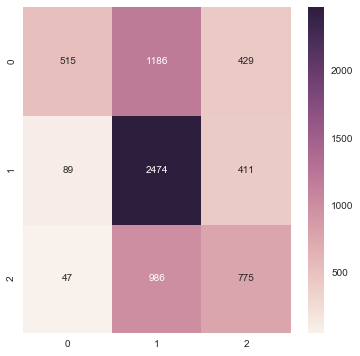

In [89]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_flatten,final_predictions_flatten),annot=True, fmt="d")

In [90]:
matches_prob = model.predict_proba(X_test)

288/288 [==============================] - 0s     


#### only test samples checking


In [91]:
total_valid_samples = 0
correct_valid_samples = 0
index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]
first_iter = True
index_list = []
for match_id in index_test_unique:
    matches_idxs = np.where(index_test == match_id)
    if len(matches_idxs[0])==2:
        first_team_prob = matches_prob[matches_idxs[0][0],matches_idxs[1][0],:]
        second_team_prob = matches_prob[matches_idxs[0][1],matches_idxs[1][1],:]
        mean_prob = np.mean([first_team_prob,second_team_prob],axis=0)
        if first_iter:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat = mean_prob_temp
                index_list.append(int(match_id))
                first_iter = False
        else:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat = np.concatenate((mean_prob_mat,mean_prob_temp),axis=0)
                index_list.append(int(match_id))
        label = np.where(y_test[matches_idxs[0][0],matches_idxs[1][0],:] == 1)
        prediction = mean_prob.argmax()
        if (prediction == label):
            correct_valid_samples+=1
        total_valid_samples+=1
print("{}/{}={}".format(correct_valid_samples,total_valid_samples,correct_valid_samples/total_valid_samples) )

1663/3231=0.5147013308573197


In [92]:
d = {'0' : pd.Series(mean_prob_mat[:,0], index=index_list),
     '1' : pd.Series(mean_prob_mat[:,1], index=index_list),
     '2' : pd.Series(mean_prob_mat[:,2], index=index_list)}
LSTM_test_matches_prob = pd.DataFrame(d)
LSTM_test_matches_prob.head()


,0,1,2
900,0.226659,0.623530,0.149811
901,0.298622,0.438895,0.262482
902,0.268639,0.490747,0.240614
903,0.309850,0.373371,0.316779
904,0.277931,0.486984,0.235085


In [93]:
index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]
print(np.where(index_test_unique == -1))
index_test_unique

(array([], dtype=int64),)


array([   900.,    901.,    902., ...,  12873.,  12874.,  12875.])

#### using all data samples -  test and train

In [99]:
# matches_prob = model.predict_proba(LSTM_matches)

In [100]:
# total_valid_samples = 0
# correct_valid_samples = 0
# matches_id_unique = np.unique(Matches_id)
# for match_id in matches_id_unique:
#     matches_idxs = np.where(Matches_id == match_id)
#     if len(matches_idxs[0])==2:
#         first_team_prob = matches_prob[matches_idxs[0][0],matches_idxs[1][0],:]
#         second_team_prob = matches_prob[matches_idxs[0][1],matches_idxs[1][1],:]
#         mean_prob = np.mean([first_team_prob,second_team_prob],axis=0)
#         label = np.where(Y_train[matches_idxs[0][0],matches_idxs[1][0],:] == 1)
#         prediction = mean_prob.argmax()
#         if (prediction == label):
#             correct_valid_samples+=1
#         total_valid_samples+=1
# print("{}/{}={}".format(correct_valid_samples,total_valid_samples,correct_valid_samples/total_valid_samples) )

In [101]:
# model.summary()
# print("Inputs: {}".format(model.input_shape))
# print("Outputs: {}".format(model.output_shape))
# print("Actual input: {}".format(X_train.shape))
# print("Actual output: {}".format(y_train.shape))

In [102]:
#a = matches_per_team_season2.as_matrix()
#np.shape(a)

In [103]:
#b=[[1,2,3],[4,5,6]]
#c= np.array(b)
#e=np.array([])
#e=np.expand_dims(e, axis=0)
#np.shape(c)

In [104]:
#np.concatenate((e,c),axis=0)

In [105]:
#d = np.expand_dims(c, axis=0)
#np.shape(d)

In [106]:
#x = np.ones((1, 2, 3))
#np.transpose(x, (1, 0, 2)).shape

In [107]:
#frames = [matches_per_team_season1, matches_per_team_season2]

#result = pd.concat(frames)
#result